In [1]:
# base imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Важная настройка для корректной настройки pipeline!
import sklearn
sklearn.set_config(transform_output="pandas")

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# for model learning
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import category_encoders as ce

# Models
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import lightgbm as lgb # устоявшееся соглашение импорта
from lightgbm import LGBMRegressor

# Metrics
from sklearn.metrics import mean_squared_log_error, mean_squared_error, mean_absolute_error, r2_score

# Tuning parametrs
import optuna

# notebook settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

### 0. Загрузка датасета

In [6]:
df = pd.read_csv('/Users/alex_eyfler/ds_bootcamp/first-phase-projects/house_prices_kaggle_regression/Lambert/Hope_works_train.csv')

X, y_log = df.drop('SalePrice', axis=1), np.log(df['SalePrice'])

X_train, X_valid, y_log_train, y_log_valid = train_test_split(
    X,
    y_log,
    test_size=0.2,
    random_state=52
)

### 1. Пробуем CatBoost с базовыми настройками

In [ ]:
cat_boost_1 = CatBoostRegressor()

cat_boost_1.fit(
    X_train,
    y_log_train
)

#### 1.1 Получение предсказаний и обработка метрик

In [21]:
# Предсказания на логарифмических данных
y_log_train_pred = cat_boost_1.predict(X_train)
y_log_valid_pred = cat_boost_1.predict(X_valid)

# Перевод предсказанных значений в обычную шкалу для дальнейшего анализа
y_train_pred = np.exp(y_log_train_pred)
y_valid_pred = np.exp(y_log_valid_pred)

# И для оригинальных значений
y_train = np.exp(y_log_train)
y_valid = np.exp(y_log_valid)


# Проверяем, что в целевых значениях и предсказаниях нет отрицательных значений
if (y_train < 0).any() or (y_valid < 0).any() or (y_train_pred < 0).any() or (y_valid_pred < 0).any():
    print("RMSLE не может быть применена, так как имеются отрицательные значения в y или в предсказаниях.")
else:
    # Вычисляем MSLE и RMSLE
    train_msle = mean_squared_log_error(y_train, y_train_pred)
    valid_msle = mean_squared_log_error(y_valid, y_valid_pred)

    print('Train MSLE:', train_msle)
    print('Validation MSLE:', valid_msle)
    print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

    print('Train RMSLE:', np.sqrt(train_msle))
    print('Validation RMSLE:', np.sqrt(valid_msle))
    print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Вычисляем другие метрики для более полной оценки модели

# Среднеквадратичная ошибка (MSE) и корень из MSE (RMSE)
train_mse = mean_squared_error(y_train, y_train_pred)
valid_mse = mean_squared_error(y_valid, y_valid_pred)

print('Train MSE:', train_mse)
print('Validation MSE:', valid_mse)
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

print('Train RMSE:', np.sqrt(train_mse))
print('Validation RMSE:', np.sqrt(valid_mse))
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Средняя абсолютная ошибка (MAE)
train_mae = mean_absolute_error(y_train, y_train_pred)
valid_mae = mean_absolute_error(y_valid, y_valid_pred)

print('Train MAE:', train_mae)
print('Validation MAE:', valid_mae)
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Коэффициент детерминации (R²)
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print('Train R^2:', train_r2)
print('Validation R^2:', valid_r2)

Train MSLE: 0.0011021891469171295
Validation MSLE: 0.016391738733750962


Train RMSLE: 0.03319923413148456
Validation RMSLE: 0.1280302258599545


Train MSE: 39196873.478255935
Validation MSE: 748182501.2886821


Train RMSE: 6260.740649336621
Validation RMSE: 27352.924912862283


Train MAE: 4558.562653695426
Validation MAE: 15268.570810332305


Train R^2: 0.9933495448172416
Validation R^2: 0.905590778920019


### 2. Пробуем XGBoost с базовыми настройками

In [9]:
xgb_boost_1 = XGBRegressor()

xgb_boost_1.fit(
    X_train,
    y_log_train
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### 2.1 Получение предсказаний и обработка метрик

In [10]:
# Предсказания на логарифмических данных
y_log_train_pred = xgb_boost_1.predict(X_train)
y_log_valid_pred = xgb_boost_1.predict(X_valid)

# Перевод предсказанных значений в обычную шкалу для дальнейшего анализа
y_train_pred = np.exp(y_log_train_pred)
y_valid_pred = np.exp(y_log_valid_pred)

# И для оригинальных значений
y_train = np.exp(y_log_train)
y_valid = np.exp(y_log_valid)


# Проверяем, что в целевых значениях и предсказаниях нет отрицательных значений
if (y_train < 0).any() or (y_valid < 0).any() or (y_train_pred < 0).any() or (y_valid_pred < 0).any():
    print("RMSLE не может быть применена, так как имеются отрицательные значения в y или в предсказаниях.")
else:
    # Вычисляем MSLE и RMSLE
    train_msle = mean_squared_log_error(y_train, y_train_pred)
    valid_msle = mean_squared_log_error(y_valid, y_valid_pred)

    print('Train MSLE:', train_msle)
    print('Validation MSLE:', valid_msle)
    print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

    print('Train RMSLE:', np.sqrt(train_msle))
    print('Validation RMSLE:', np.sqrt(valid_msle))
    print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Вычисляем другие метрики для более полной оценки модели

# Среднеквадратичная ошибка (MSE) и корень из MSE (RMSE)
train_mse = mean_squared_error(y_train, y_train_pred)
valid_mse = mean_squared_error(y_valid, y_valid_pred)

print('Train MSE:', train_mse)
print('Validation MSE:', valid_mse)
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

print('Train RMSE:', np.sqrt(train_mse))
print('Validation RMSE:', np.sqrt(valid_mse))
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Средняя абсолютная ошибка (MAE)
train_mae = mean_absolute_error(y_train, y_train_pred)
valid_mae = mean_absolute_error(y_valid, y_valid_pred)

print('Train MAE:', train_mae)
print('Validation MAE:', valid_mae)
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Коэффициент детерминации (R²)
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print('Train R^2:', train_r2)
print('Validation R^2:', valid_r2)

Train MSLE: 2.2233546157156557e-05
Validation MSLE: 0.022997083337789652


Train RMSLE: 0.0047152461396152544
Validation RMSLE: 0.15164789262561368


Train MSE: 718597.9046213459
Validation MSE: 960402632.2371984


Train RMSE: 847.7015421841262
Validation RMSE: 30990.36353831943


Train MAE: 576.269046313145
Validation MAE: 18349.74775256849


Train R^2: 0.9998780769297388
Validation R^2: 0.8788118349780912


### 3. Пробуем LightGBM с базовыми настройками

In [11]:
lightgb_boost_1 = LGBMRegressor()

lightgb_boost_1.fit(
    X_train,
    y_log_train
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3111
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 72
[LightGBM] [Info] Start training from score 12.020874


LGBMRegressor()

#### 3.1 Получение предсказаний и обработка метрик

In [12]:
# Предсказания на логарифмических данных
y_log_train_pred = lightgb_boost_1.predict(X_train)
y_log_valid_pred = lightgb_boost_1.predict(X_valid)

# Перевод предсказанных значений в обычную шкалу для дальнейшего анализа
y_train_pred = np.exp(y_log_train_pred)
y_valid_pred = np.exp(y_log_valid_pred)

# И для оригинальных значений
y_train = np.exp(y_log_train)
y_valid = np.exp(y_log_valid)


# Проверяем, что в целевых значениях и предсказаниях нет отрицательных значений
if (y_train < 0).any() or (y_valid < 0).any() or (y_train_pred < 0).any() or (y_valid_pred < 0).any():
    print("RMSLE не может быть применена, так как имеются отрицательные значения в y или в предсказаниях.")
else:
    # Вычисляем MSLE и RMSLE
    train_msle = mean_squared_log_error(y_train, y_train_pred)
    valid_msle = mean_squared_log_error(y_valid, y_valid_pred)

    print('Train MSLE:', train_msle)
    print('Validation MSLE:', valid_msle)
    print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

    print('Train RMSLE:', np.sqrt(train_msle))
    print('Validation RMSLE:', np.sqrt(valid_msle))
    print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Вычисляем другие метрики для более полной оценки модели

# Среднеквадратичная ошибка (MSE) и корень из MSE (RMSE)
train_mse = mean_squared_error(y_train, y_train_pred)
valid_mse = mean_squared_error(y_valid, y_valid_pred)

print('Train MSE:', train_mse)
print('Validation MSE:', valid_mse)
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

print('Train RMSE:', np.sqrt(train_mse))
print('Validation RMSE:', np.sqrt(valid_mse))
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Средняя абсолютная ошибка (MAE)
train_mae = mean_absolute_error(y_train, y_train_pred)
valid_mae = mean_absolute_error(y_valid, y_valid_pred)

print('Train MAE:', train_mae)
print('Validation MAE:', valid_mae)
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Коэффициент детерминации (R²)
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print('Train R^2:', train_r2)
print('Validation R^2:', valid_r2)

Train MSLE: 0.00152493467650857
Validation MSLE: 0.018918078510511714


Train RMSLE: 0.03905041198897356
Validation RMSLE: 0.13754300603997177


Train MSE: 79307421.46717928
Validation MSE: 823587110.0759846


Train RMSE: 8905.471434302583
Validation RMSE: 28698.207436632423


Train MAE: 4637.826017644174
Validation MAE: 16941.013918041812


Train R^2: 0.9865440683063612
Validation R^2: 0.8960758672919227


### 4. Тюнинг параметров для моделей

### 4.1 CatBoost тюнинг

In [13]:
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 500, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
    }
    model = CatBoostRegressor(**param, verbose=0)
    model.fit(X_train, y_log_train, eval_set=(X_valid, y_log_valid), early_stopping_rounds=50)
    log_preds = model.predict(X_valid)
    preds = np.exp(log_preds)
    msle = mean_squared_log_error(y_valid, preds)
    rmsle = np.sqrt(msle)
    return rmsle

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print('Наилучшие параметры:')
for key, value in study.best_params.items():
    print(f'{key}: {value}')

print(f'Наилучшее значение RMSLE: {study.best_value}')

[I 2024-09-27 16:08:37,815] A new study created in memory with name: no-name-d61098c6-85dd-49f4-8df4-82e73e4f9513
[I 2024-09-27 16:08:39,788] Trial 0 finished with value: 0.16079630977505144 and parameters: {'iterations': 1128, 'learning_rate': 0.13867904763476666, 'depth': 10, 'l2_leaf_reg': 1.0311597914629318, 'bagging_temperature': 0.29480220981061933, 'random_strength': 5.809610925270643, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.16079630977505144.
[I 2024-09-27 16:08:40,418] Trial 1 finished with value: 0.13478392660284008 and parameters: {'iterations': 1611, 'learning_rate': 0.06823583376378901, 'depth': 5, 'l2_leaf_reg': 7.047012294114621, 'bagging_temperature': 0.7238326618025207, 'random_strength': 0.3965749151840603, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.13478392660284008.
[I 2024-09-27 16:08:41,395] Trial 2 finished with value: 0.13093199384483895 and parameters: {'iterations': 1158, 'learning_rate': 0.050532239443408525, 'depth'

Наилучшие параметры:
iterations: 1241
learning_rate: 0.06071716565899703
depth: 4
l2_leaf_reg: 7.76892727416148
bagging_temperature: 0.961745094190735
random_strength: 4.9804828019633165
grow_policy: Lossguide
Наилучшее значение RMSLE: 0.12333375686301161


### 4.2 XGBoost тюнинг

In [ ]:
# def objective(trial):
#     param = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'max_depth': trial.suggest_int('max_depth', 3, 10),
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'gamma': trial.suggest_float('gamma', 0, 5),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
#     }
#     model = XGBRegressor(**param)
#     model.fit(X_train, y_log_train, eval_set=[(X_valid, y_log_valid)], verbose=False)
#     log_preds = model.predict(X_valid)
#     preds = np.exp(log_preds)
#     msle = mean_squared_log_error(y_valid, preds)
#     rmsle = np.sqrt(msle)
#     return rmsle

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Наилучшие параметры:')
# for key, value in study.best_params.items():
#     print(f'{key}: {value}')

# print(f'Наилучшее значение RMSLE: {study.best_value}')

### 4.3 LightGBM тюнинг

In [ ]:
# def objective(trial):
#     param = {
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'max_depth': trial.suggest_int('max_depth', -1, 15),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
#         'min_split_gain': trial.suggest_float('min_split_gain', 0, 0.5),
#     }
#     model = LGBMRegressor(**param)
#     model.fit(X_train, y_log_train, eval_set=[(X_valid, y_log_valid)])
#     log_preds = model.predict(X_valid)
#     preds = np.exp(log_preds)
#     msle = mean_squared_log_error(y_valid, preds)
#     rmsle = np.sqrt(msle)
#     return rmsle

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print('Наилучшие параметры:')
# for key, value in study.best_params.items():
#     print(f'{key}: {value}')

# print(f'Наилучшее значение RMSLE: {study.best_value}')

### 5. Проверка моделей с оптимизированными параметрами

### 5.1 CatBoost оптимизированная

In [ ]:
# Наилучшие параметры: МОИ ПЕРВЫЕ
# iterations: 1842
# learning_rate: 0.148683039214686
# depth: 4
# l2_leaf_reg: 8.976684403702432
# bagging_temperature: 0.6928364121029715
# random_strength: 3.0234103345423176
# grow_policy: SymmetricTree
# Наилучшее значение RMSLE: 0.138473644119397

# Наилучшие параметры: МАРИНА ПРЕПРОЦЕССИНГ
# iterations: 900
# learning_rate: 0.03811379337443099
# depth: 4
# l2_leaf_reg: 5.401132284019045
# bagging_temperature: 0.7921960733675621
# random_strength: 7.0013473823336065
# grow_policy: Lossguide
# Наилучшее значение RMSLE: 0.1407241390521044

# Наилучшие параметры: ЛАМБЕРТ ПРЕПРОЦЕССИНГ
# iterations: 1241
# learning_rate: 0.06071716565899703
# depth: 4
# l2_leaf_reg: 7.76892727416148
# bagging_temperature: 0.961745094190735
# random_strength: 4.9804828019633165
# grow_policy: Lossguide
# Наилучшее значение RMSLE: 0.12333375686301161

In [ ]:
cat_boost_2 = CatBoostRegressor(
    iterations=1241,
    learning_rate=0.06071716565899703,
    depth=4,
    l2_leaf_reg=7.76892727416148,
    bagging_temperature=0.961745094190735,
    random_strength=4.9804828019633165,
    grow_policy='Lossguide'
)

cat_boost_2.fit(
    X_train,
    y_log_train
)

Train MSLE: 0.001652910382705165
Validation MSLE: 0.015429854571252255


Train RMSLE: 0.04065600057439449
Validation RMSLE: 0.1242169657142383


Train MSE: 55542607.99685634
Validation MSE: 515970479.982843


Train RMSE: 7452.691325746448
Validation RMSE: 22714.98360076104


Train MAE: 5196.909692381249
Validation MAE: 14541.499793902996


Train R^2: 0.9905761967106502
Validation R^2: 0.9348923945273498


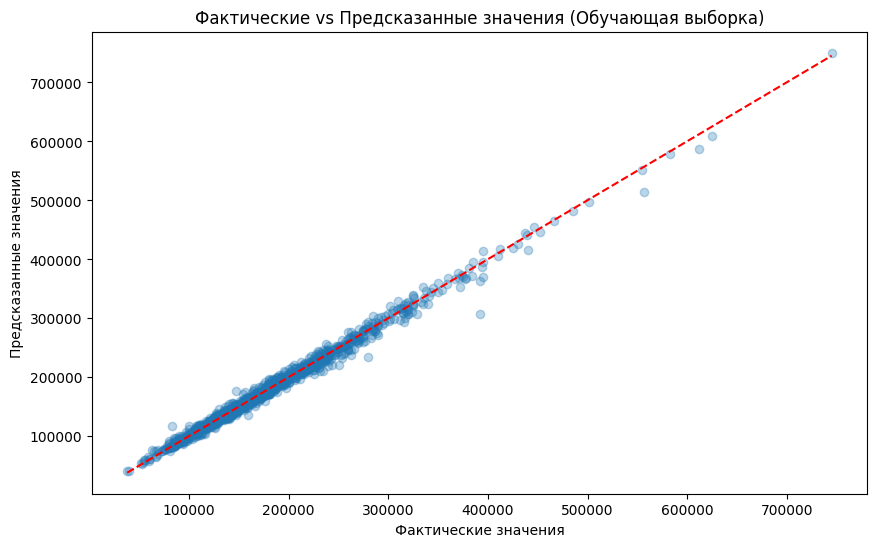

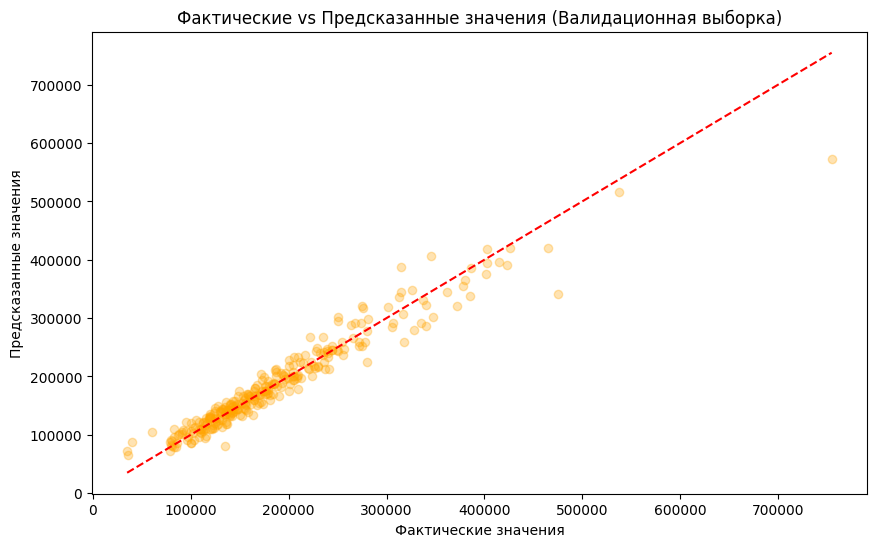

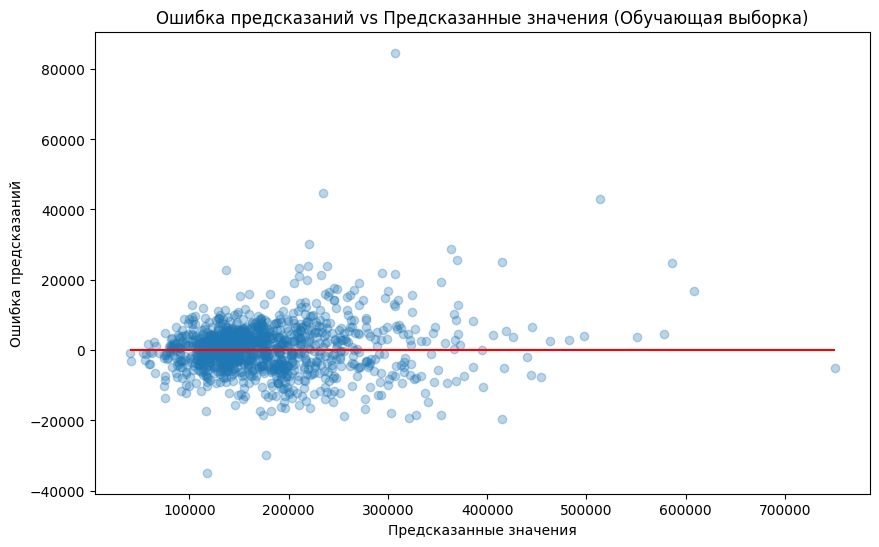

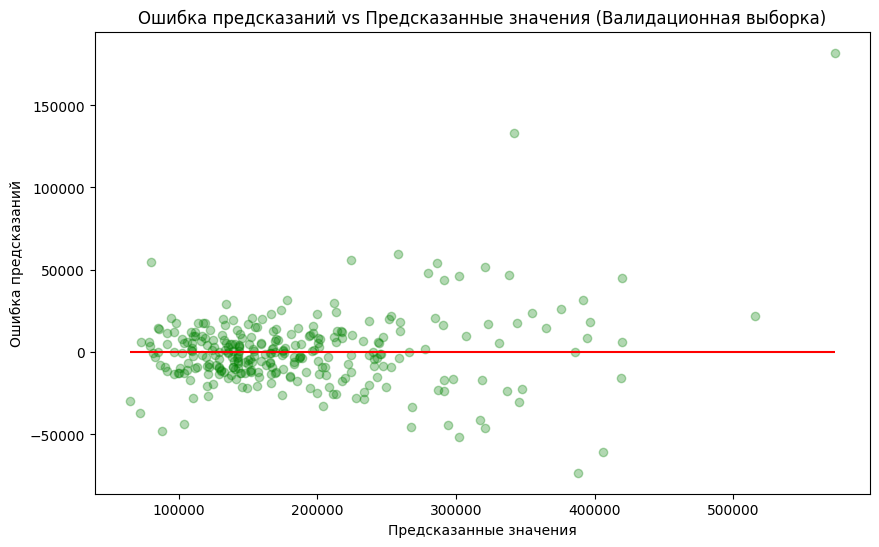

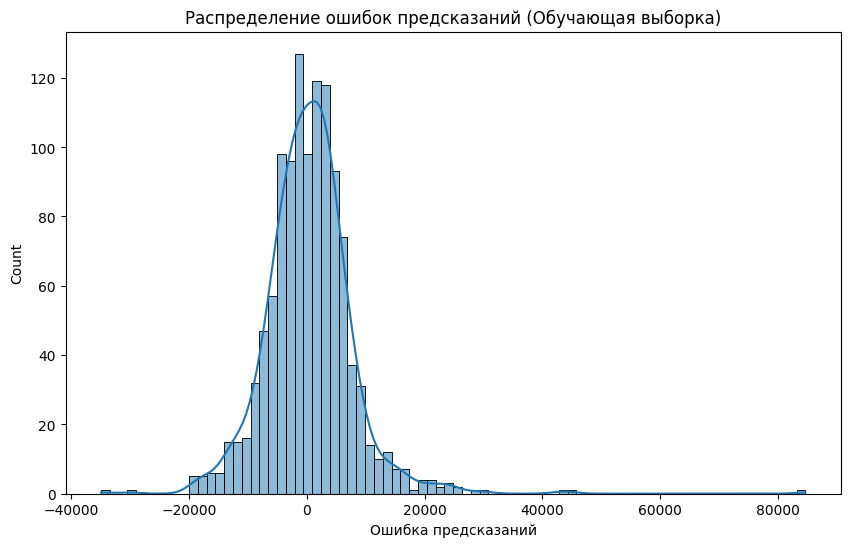

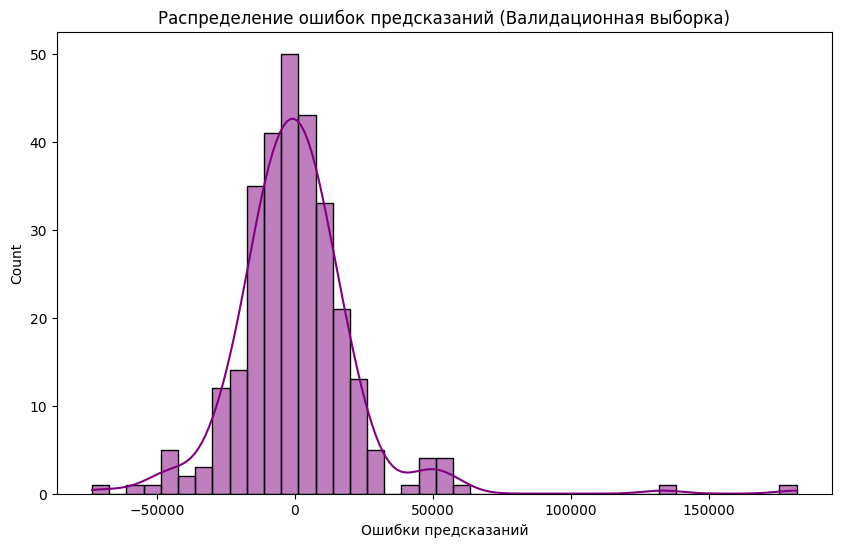

In [20]:
# Предсказания на логарифмических данных
y_log_train_pred = cat_boost_2.predict(X_train)
y_log_valid_pred = cat_boost_2.predict(X_valid)

# Перевод предсказанных значений в обычную шкалу для дальнейшего анализа
y_train_pred = np.exp(y_log_train_pred)
y_valid_pred = np.exp(y_log_valid_pred)

# И для оригинальных значений
y_train = np.exp(y_log_train)
y_valid = np.exp(y_log_valid)


# Проверяем, что в целевых значениях и предсказаниях нет отрицательных значений
if (y_train < 0).any() or (y_valid < 0).any() or (y_train_pred < 0).any() or (y_valid_pred < 0).any():
    print("RMSLE не может быть применена, так как имеются отрицательные значения в y или в предсказаниях.")
else:
    # Вычисляем MSLE и RMSLE
    train_msle = mean_squared_log_error(y_train, y_train_pred)
    valid_msle = mean_squared_log_error(y_valid, y_valid_pred)

    print('Train MSLE:', train_msle)
    print('Validation MSLE:', valid_msle)
    print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

    print('Train RMSLE:', np.sqrt(train_msle))
    print('Validation RMSLE:', np.sqrt(valid_msle))
    print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Вычисляем другие метрики для более полной оценки модели

# Среднеквадратичная ошибка (MSE) и корень из MSE (RMSE)
train_mse = mean_squared_error(y_train, y_train_pred)
valid_mse = mean_squared_error(y_valid, y_valid_pred)

print('Train MSE:', train_mse)
print('Validation MSE:', valid_mse)
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

print('Train RMSE:', np.sqrt(train_mse))
print('Validation RMSE:', np.sqrt(valid_mse))
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Средняя абсолютная ошибка (MAE)
train_mae = mean_absolute_error(y_train, y_train_pred)
valid_mae = mean_absolute_error(y_valid, y_valid_pred)

print('Train MAE:', train_mae)
print('Validation MAE:', valid_mae)
print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# Коэффициент детерминации (R²)
train_r2 = r2_score(y_train, y_train_pred)
valid_r2 = r2_score(y_valid, y_valid_pred)

print('Train R^2:', train_r2)
print('Validation R^2:', valid_r2)

# Добавляем графическое представление метрик

# 1. Фактические значения vs Предсказанные значения (Обучающая выборка)
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения (Обучающая выборка)')
plt.show()

# 2. Фактические значения vs Предсказанные значения (Валидационная выборка)
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_valid_pred, alpha=0.3, color='orange')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('Фактические значения')
plt.ylabel('Предсказанные значения')
plt.title('Фактические vs Предсказанные значения (Валидационная выборка)')
plt.show()

# 3. Ошибка предсказаний vs Предсказанные значения (Обучающая выборка)
train_residuals = y_train - y_train_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_train_pred, train_residuals, alpha=0.3)
plt.hlines(y=0, xmin=y_train_pred.min(), xmax=y_train_pred.max(), colors='r')
plt.xlabel('Предсказанные значения')
plt.ylabel('Ошибка предсказаний')
plt.title('Ошибка предсказаний vs Предсказанные значения (Обучающая выборка)')
plt.show()

# 4. Ошибка предсказаний vs Предсказанные значения (Валидационная выборка)
valid_residuals = y_valid - y_valid_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_valid_pred, valid_residuals, alpha=0.3, color='green')
plt.hlines(y=0, xmin=y_valid_pred.min(), xmax=y_valid_pred.max(), colors='r')
plt.xlabel('Предсказанные значения')
plt.ylabel('Ошибка предсказаний')
plt.title('Ошибка предсказаний vs Предсказанные значения (Валидационная выборка)')
plt.show()

# 5. Гистограмма распределения ошибки предсказаний (Обучающая выборка)
plt.figure(figsize=(10, 6))
sns.histplot(train_residuals, kde=True)
plt.xlabel('Ошибка предсказаний')
plt.title('Распределение ошибок предсказаний (Обучающая выборка)')
plt.show()

# 6. Гистограмма распределения остатков (Валидационная выборка)
plt.figure(figsize=(10, 6))
sns.histplot(valid_residuals, kde=True, color='purple')
plt.xlabel('Ошибки предсказаний')
plt.title('Распределение ошибок предсказаний (Валидационная выборка)')
plt.show()

### 5.2 XGBoost оптимизированная

In [ ]:
# Наилучшие параметры:
# n_estimators: 327
# learning_rate: 0.19004499200202402
# max_depth: 4
# min_child_weight: 9
# subsample: 0.7652336374371225
# colsample_bytree: 0.9987214725990732
# gamma: 0.014535992949008314
# reg_alpha: 0.09623153707588272
# reg_lambda: 1.097540050285076
# Наилучшее значение RMSLE: 0.14748199698692188

# Наилучшие параметры:
# n_estimators: 844
# learning_rate: 0.08164455058834777
# max_depth: 8
# min_child_weight: 9
# subsample: 0.7238340018204652
# colsample_bytree: 0.8971439859788364
# gamma: 0.09651374849246132
# reg_alpha: 0.2873373023225376
# reg_lambda: 0.044214936059544685
# Наилучшее значение RMSLE: 0.1485642257738933



In [ ]:
# xgb_boost_2 = XGBRegressor(
#     n_estimators=844,
#     learning_rate=0.08164455058834777,
#     max_depth=8,
#     min_child_weight=9,
#     subsample=0.7238340018204652,
#     colsample_bytree=0.8971439859788364,
#     gamma=0.09651374849246132,
#     reg_alpha=0.2873373023225376,
#     reg_lambda=0.044214936059544685
# )

# xgb_boost_2.fit(
#     X_train,
#     y_log_train
# )

In [ ]:
# # Предсказания на логарифмических данных
# y_log_train_pred = xgb_boost_2.predict(X_train)
# y_log_valid_pred = xgb_boost_2.predict(X_valid)

# # Перевод предсказанных значений в обычную шкалу для дальнейшего анализа
# y_train_pred = np.exp(y_log_train_pred)
# y_valid_pred = np.exp(y_log_valid_pred)

# # И для оригинальных значений
# y_train = np.exp(y_log_train)
# y_valid = np.exp(y_log_valid)


# # Проверяем, что в целевых значениях и предсказаниях нет отрицательных значений
# if (y_train < 0).any() or (y_valid < 0).any() or (y_train_pred < 0).any() or (y_valid_pred < 0).any():
#     print("RMSLE не может быть применена, так как имеются отрицательные значения в y или в предсказаниях.")
# else:
#     # Вычисляем MSLE и RMSLE
#     train_msle = mean_squared_log_error(y_train, y_train_pred)
#     valid_msle = mean_squared_log_error(y_valid, y_valid_pred)

#     print('Train MSLE:', train_msle)
#     print('Validation MSLE:', valid_msle)
#     print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

#     print('Train RMSLE:', np.sqrt(train_msle))
#     print('Validation RMSLE:', np.sqrt(valid_msle))
#     print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# # Вычисляем другие метрики для более полной оценки модели

# # Среднеквадратичная ошибка (MSE) и корень из MSE (RMSE)
# train_mse = mean_squared_error(y_train, y_train_pred)
# valid_mse = mean_squared_error(y_valid, y_valid_pred)

# print('Train MSE:', train_mse)
# print('Validation MSE:', valid_mse)
# print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# print('Train RMSE:', np.sqrt(train_mse))
# print('Validation RMSE:', np.sqrt(valid_mse))
# print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# # Средняя абсолютная ошибка (MAE)
# train_mae = mean_absolute_error(y_train, y_train_pred)
# valid_mae = mean_absolute_error(y_valid, y_valid_pred)

# print('Train MAE:', train_mae)
# print('Validation MAE:', valid_mae)
# print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# # Коэффициент детерминации (R²)
# train_r2 = r2_score(y_train, y_train_pred)
# valid_r2 = r2_score(y_valid, y_valid_pred)

# print('Train R^2:', train_r2)
# print('Validation R^2:', valid_r2)

### 5.3 LightGBM оптимизированная

In [ ]:
# Наилучшие параметры:
# num_leaves: 113
# max_depth: 1
# learning_rate: 0.10903967197428367
# n_estimators: 778
# min_child_samples: 9
# subsample: 0.8742544778238289
# colsample_bytree: 0.9009601449135453
# reg_alpha: 0.28329210432059404
# reg_lambda: 1.7573468439270545
# min_split_gain: 0.015184427785830778
# Наилучшее значение RMSLE: 0.147169218625256

# Наилучшие параметры:
# num_leaves: 57
# max_depth: 4
# learning_rate: 0.10740934748332331
# n_estimators: 303
# min_child_samples: 16
# subsample: 0.8820522868683773
# colsample_bytree: 0.8705970453414562
# reg_alpha: 0.6270574626923819
# reg_lambda: 0.5092506334428395
# min_split_gain: 0.009609703392432955
# Наилучшее значение RMSLE: 0.15048997184353413



In [ ]:
# lightgb_boost_2 = LGBMRegressor(
#     num_leaves=57,
#     max_depth=4,
#     learning_rate=0.10740934748332331,
#     n_estimators=303,
#     min_child_samples=16,
#     subsample=0.8820522868683773,
#     colsample_bytree=0.8705970453414562,
#     reg_alpha=0.6270574626923819,
#     reg_lambda=0.5092506334428395,
#     min_split_gain=0.009609703392432955
# )

# lightgb_boost_2.fit(
#     X_train,
#     y_log_train
# )

In [ ]:
# # Предсказания на логарифмических данных
# y_log_train_pred = lightgb_boost_2.predict(X_train)
# y_log_valid_pred = lightgb_boost_2.predict(X_valid)

# # Перевод предсказанных значений в обычную шкалу для дальнейшего анализа
# y_train_pred = np.exp(y_log_train_pred)
# y_valid_pred = np.exp(y_log_valid_pred)

# # И для оригинальных значений
# y_train = np.exp(y_log_train)
# y_valid = np.exp(y_log_valid)


# # Проверяем, что в целевых значениях и предсказаниях нет отрицательных значений
# if (y_train < 0).any() or (y_valid < 0).any() or (y_train_pred < 0).any() or (y_valid_pred < 0).any():
#     print("RMSLE не может быть применена, так как имеются отрицательные значения в y или в предсказаниях.")
# else:
#     # Вычисляем MSLE и RMSLE
#     train_msle = mean_squared_log_error(y_train, y_train_pred)
#     valid_msle = mean_squared_log_error(y_valid, y_valid_pred)

#     print('Train MSLE:', train_msle)
#     print('Validation MSLE:', valid_msle)
#     print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

#     print('Train RMSLE:', np.sqrt(train_msle))
#     print('Validation RMSLE:', np.sqrt(valid_msle))
#     print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# # Вычисляем другие метрики для более полной оценки модели

# # Среднеквадратичная ошибка (MSE) и корень из MSE (RMSE)
# train_mse = mean_squared_error(y_train, y_train_pred)
# valid_mse = mean_squared_error(y_valid, y_valid_pred)

# print('Train MSE:', train_mse)
# print('Validation MSE:', valid_mse)
# print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# print('Train RMSE:', np.sqrt(train_mse))
# print('Validation RMSE:', np.sqrt(valid_mse))
# print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# # Средняя абсолютная ошибка (MAE)
# train_mae = mean_absolute_error(y_train, y_train_pred)
# valid_mae = mean_absolute_error(y_valid, y_valid_pred)

# print('Train MAE:', train_mae)
# print('Validation MAE:', valid_mae)
# print("\n" + "="*30 + "\n")  # Разделитель для удобства чтения

# # Коэффициент детерминации (R²)
# train_r2 = r2_score(y_train, y_train_pred)
# valid_r2 = r2_score(y_valid, y_valid_pred)

# print('Train R^2:', train_r2)
# print('Validation R^2:', valid_r2)

### 6. Получение результатов и загрузка

In [16]:
# загрузка датасета для заполнения ответами
df_answer = pd.read_csv('../sample_submission.csv')

# загрузка датасета для проведения предсказания
df_test = pd.read_csv('/Users/alex_eyfler/ds_bootcamp/first-phase-projects/house_prices_kaggle_regression/Lambert/Lam_test.csv')

In [17]:
# Предсказания на логарифмических данных
y_log_test_pred = cat_boost_2.predict(df_test)

# Возвращаемся к исходной шкале
y_test_pred = np.exp(y_log_test_pred)

# Записываем ответы
df_answer['SalePrice'] = y_test_pred

# Сохраняем ответы для отправки на Kaggle
df_answer.to_csv('../submission_lambert.csv', index=False)